In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#logistic, random forest, xgboost, knn, decision tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
#scipy stats circle import
from scipy.stats import circmean, circstd, vonmises
import joblib

In [65]:
data_test = pd.read_csv('fraudTest.csv')

In [66]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [67]:
data_test.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [68]:
data_test.isnull().sum().sum()

np.int64(0)

In [69]:
data_test.duplicated().sum()


np.int64(0)

In [70]:
data_test['trans_date_trans_time'] = pd.to_datetime(data_test['trans_date_trans_time'])

data_test['Hour'] = data_test['trans_date_trans_time'].dt.hour
data_test['DayOfWeek'] = data_test['trans_date_trans_time'].dt.dayofweek
data_test['Month'] = data_test['trans_date_trans_time'].dt.month
data_test['Weekend'] = data_test['DayOfWeek'].isin([5, 6]).astype(int)

In [71]:
# assume data_test['trans_date_trans_time'] is datetime
data_test['hour'] = data_test['trans_date_trans_time'].dt.hour + data_test['trans_date_trans_time'].dt.minute/60

data_test['theta'] = 2 * np.pi * data_test['hour'] / 24

mu_vm = circmean(data_test['theta'], high=2*np.pi, low=0)
sigma_vm = circstd(data_test['theta'], high=2*np.pi, low=0)

# von Mises pdf value for each transaction time
data_test['vm_pdf'] = vonmises.pdf(data_test['theta'], kappa=1/sigma_vm, loc=mu_vm)

# distance from periodic mean (in radians)
data_test['vm_distance'] = np.cos(data_test['theta'] - mu_vm)

# indicator: how unusual is this transaction time?
data_test['vm_anomaly'] = (data_test['vm_pdf'] < data_test['vm_pdf'].quantile(0.05)).astype(int)

def customer_vm_features(subdf):
    mu = circmean(subdf['theta'], high=2*np.pi, low=0)
    sigma = circstd(subdf['theta'], high=2*np.pi, low=0)
    pdf = vonmises.pdf(subdf['theta'], kappa=1/sigma, loc=mu)
    return pd.DataFrame({
        'vm_mu': mu,
        'vm_sigma': sigma,
        'vm_pdf': pdf
    }, index=subdf.index)

data_test_vm = data_test.groupby('cc_num').apply(customer_vm_features).reset_index(level=0, drop=True)

In [72]:
data_test = pd.concat([data_test, data_test_vm], axis=1)

In [73]:
def distance_merch(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

data_test['distance_merch'] = distance_merch(data_test['lat'], data_test['long'], data_test['merch_lat'], data_test['merch_long'])

In [74]:
def age(born):
    today = pd.Timestamp('now')
    return today.year - born.year - ((today.month - born.month) < 0)

data_test['dob'] = pd.to_datetime(data_test['dob'])
data_test['age'] = data_test['dob'].apply(age)

In [75]:
#time since last transaction
data_test['trans_date_trans_time'] = pd.to_datetime(data_test['trans_date_trans_time'])
data_test['time_since_last_transaction'] = data_test.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()
data_test['time_since_last_transaction']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
555714    16630.0
555715     9743.0
555716      724.0
555717    12025.0
555718     7136.0
Name: time_since_last_transaction, Length: 555719, dtype: float64

In [76]:
#previous amount of the transaction
data_test['previous_amount'] = data_test.groupby('cc_num')['amt'].shift(1)
data_test['previous_amount']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
555714     88.60
555715      7.34
555716     47.05
555717    136.43
555718      7.29
Name: previous_amount, Length: 555719, dtype: float64

In [77]:
data_test.fillna(0, inplace = True)
data_test.isnull().sum().sum()

np.int64(0)

In [78]:
num_columns = data_test.select_dtypes(include= ['int64', 'float64'])
cat_columns = data_test.select_dtypes(include= 'object')

In [79]:
num_columns.drop(columns = ['Unnamed: 0', 'cc_num', 'zip', 'unix_time'], inplace = True)

In [80]:
import re
#remove 6 first letter from merchant columns
cat_columns['merchant'] = cat_columns['merchant'].str[6:]
#remove all number from street
def clean_street_name(street):
    # Remove leading numbers
    street = re.sub(r'^\d+\s*', '', street)
    # Remove trailing numbers
    street = re.sub(r'\s*\d+$', '', street)
    return street
cat_columns['street'] = cat_columns['street'].apply(clean_street_name)

In [81]:
cat_columns.drop( columns =  ['first','last', 'trans_num'], inplace = True)

In [82]:
df_test = pd.concat([num_columns, cat_columns], axis = 1)

In [83]:
df_test

,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,Weekend,hour,theta,...,age,time_since_last_transaction,previous_amount,merchant,category,gender,street,city,state,job
0,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0,1,12.233333,3.202679,...,57,0.0,0.00,Kirlin and Sons,personal_care,M,Darlene Green,Columbia,SC,Mechanical engineer
1,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0,1,12.233333,3.202679,...,35,0.0,0.00,Sporer-Keebler,personal_care,F,Marsh Union,Altonah,UT,"Sales professional, IT"
2,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0,1,12.233333,3.202679,...,54,0.0,0.00,"Swaniawski, Nitzsche and Welch",health_fitness,F,Valentine Point,Bellmore,NY,"Librarian, public"
3,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0,1,12.250000,3.207043,...,38,0.0,0.00,Haley Group,misc_pos,M,Krystal Mill Apt.,Titusville,FL,Set designer
4,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0,1,12.250000,3.207043,...,70,0.0,0.00,Johnston-Casper,travel,M,Evan Roads Apt.,Falmouth,MI,Furniture designer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,43.77,40.4931,-91.8912,519,39.946837,-91.333331,0,0,23.983333,6.278822,...,59,16630.0,88.60,Reilly and Sons,health_fitness,M,Michael Estates,Luray,MO,Town planner
555715,111.84,29.0393,-95.4401,28739,29.661049,-96.186633,0,0,23.983333,6.278822,...,25,9743.0,7.34,Hoppe-Parisian,kids_pets,M,Davis Mountains,Lake Jackson,TX,Futures trader
555716,86.88,46.1966,-118.9017,3684,46.658340,-119.715054,0,0,23.983333,6.278822,...,43,724.0,47.05,Rau-Robel,kids_pets,F,Evans Islands Apt.,Burbank,WA,Musician
555717,7.99,44.6255,-116.4493,129,44.470525,-117.080888,0,0,23.983333,6.278822,...,59,12025.0,136.43,Breitenberg LLC,travel,M,Doyle Stream Apt.,Mesa,ID,Cartographer


In [84]:
X = df_test.drop(columns = ['is_fraud'])
y = df_test['is_fraud']

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import joblib
oe = joblib.load('OrdinalEncoder.pkl')
X[cat_columns.columns] = oe.transform(X[cat_columns.columns])

In [86]:
scaler = joblib.load('StandardScaler.pkl')
X_scaled = scaler.transform(X)

In [95]:
import joblib

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score, roc_curve, auc,
    precision_recall_curve
)

def evaluate_model(model_path, X_scaled, y_true):
    # load model
    model = joblib.load(model_path)
    model_name = model_path.split("/")[-1]
    
    # predictions
    y_pred = model.predict(X_scaled)
    y_prob = model.predict_proba(X_scaled)[:, 1]

    # evaluation
    print(f"\n📌 {model_name}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print("PR AUC:", average_precision_score(y_true, y_prob))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, color="blue", label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, color="green", label=f"PR AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend(loc="lower left")
    plt.show()

In [96]:
# === Step 1: Collect all model filenames ===
models = [
    "Logistic Regression_nearmiss.joblib",
    "Logistic Regression_raw.joblib",
    "Logistic Regression_rud.joblib",
    "Logistic Regression_SMOTE.joblib",
    "Random Forest_nearmiss.joblib",
    "Random Forest_rud.joblib",
    "XGBoost_nearmiss.joblib",
    "XGBoost_raw.joblib",
    "XGBoost_rud.joblib",
    "XGBoost_SMOTE.joblib",
    "Decision Tree_nearmiss.joblib",
    "Decision Tree_rud.joblib"
]




📌 Logistic Regression_nearmiss.joblib
Confusion Matrix:
 [[426515 127059]
 [   283   1862]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9993    0.7705    0.8701    553574
           1     0.0144    0.8681    0.0284      2145

    accuracy                         0.7709    555719
   macro avg     0.5069    0.8193    0.4493    555719
weighted avg     0.9955    0.7709    0.8669    555719

ROC AUC: 0.8959567876211361
PR AUC: 0.14001052664565183


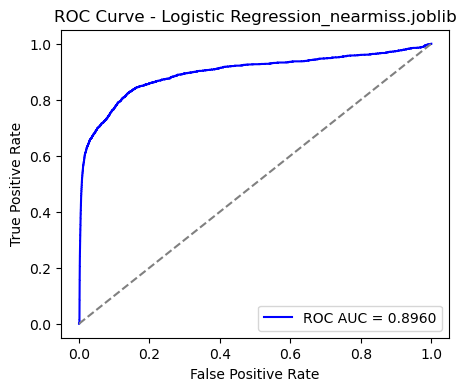

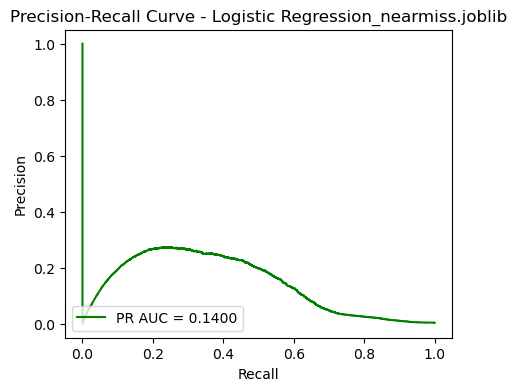


📌 Logistic Regression_raw.joblib
Confusion Matrix:
 [[525292  28282]
 [   341   1804]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9994    0.9489    0.9735    553574
           1     0.0600    0.8410    0.1119      2145

    accuracy                         0.9485    555719
   macro avg     0.5297    0.8950    0.5427    555719
weighted avg     0.9957    0.9485    0.9702    555719

ROC AUC: 0.9410838758705531
PR AUC: 0.2053990211631998


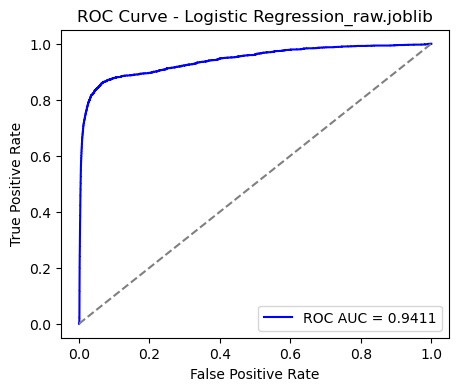

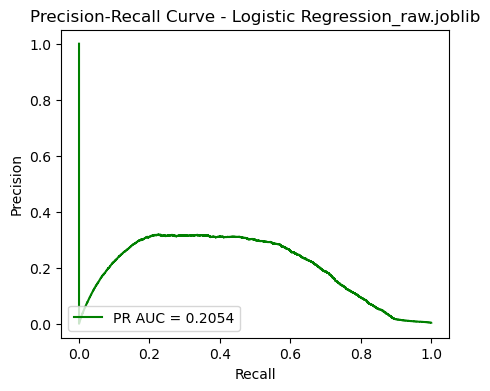


📌 Logistic Regression_rud.joblib
Confusion Matrix:
 [[526181  27393]
 [   338   1807]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9994    0.9505    0.9743    553574
           1     0.0619    0.8424    0.1153      2145

    accuracy                         0.9501    555719
   macro avg     0.5306    0.8965    0.5448    555719
weighted avg     0.9957    0.9501    0.9710    555719

ROC AUC: 0.9402559202007877
PR AUC: 0.20509120784858817


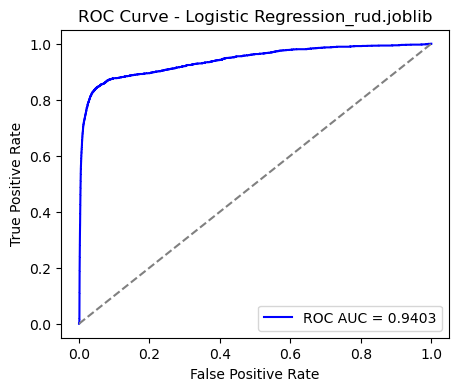

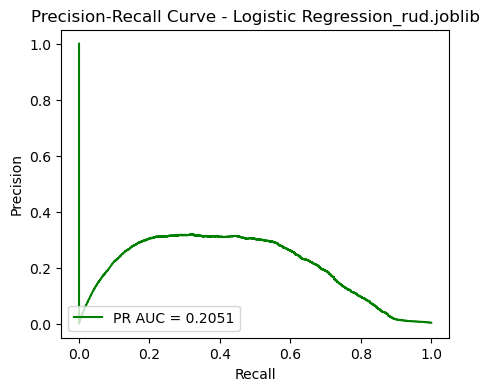


📌 Logistic Regression_SMOTE.joblib
Confusion Matrix:
 [[522870  30704]
 [   346   1799]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9993    0.9445    0.9712    553574
           1     0.0553    0.8387    0.1038      2145

    accuracy                         0.9441    555719
   macro avg     0.5273    0.8916    0.5375    555719
weighted avg     0.9957    0.9441    0.9678    555719

ROC AUC: 0.9411944108259327
PR AUC: 0.20722514704397427


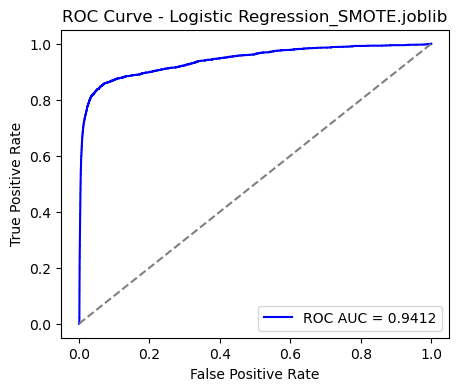

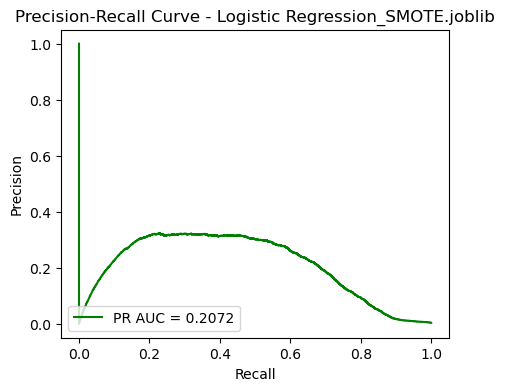


📌 Random Forest_nearmiss.joblib
Confusion Matrix:
 [[300079 253495]
 [    49   2096]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.5421    0.7030    553574
           1     0.0082    0.9772    0.0163      2145

    accuracy                         0.5438    555719
   macro avg     0.5040    0.7596    0.3596    555719
weighted avg     0.9960    0.5438    0.7004    555719

ROC AUC: 0.9671776749253292
PR AUC: 0.6044913042523882


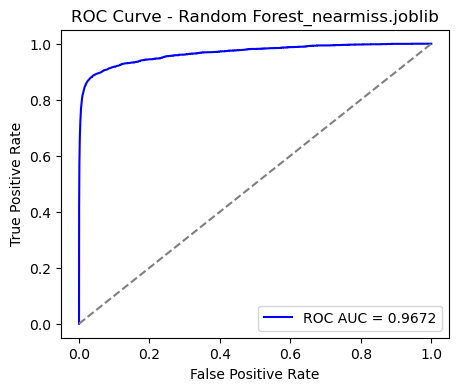

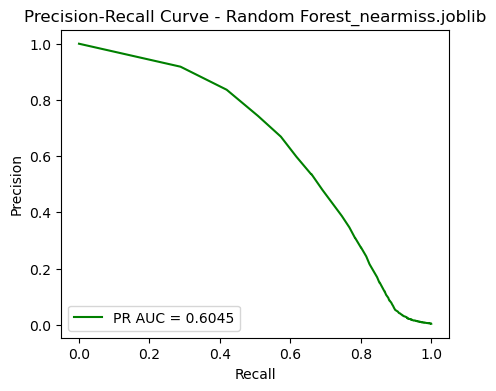


📌 Random Forest_rud.joblib
Confusion Matrix:
 [[542577  10997]
 [    84   2061]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9801    0.9899    553574
           1     0.1578    0.9608    0.2711      2145

    accuracy                         0.9801    555719
   macro avg     0.5788    0.9705    0.6305    555719
weighted avg     0.9966    0.9801    0.9871    555719

ROC AUC: 0.994597329615412
PR AUC: 0.8675542404587474


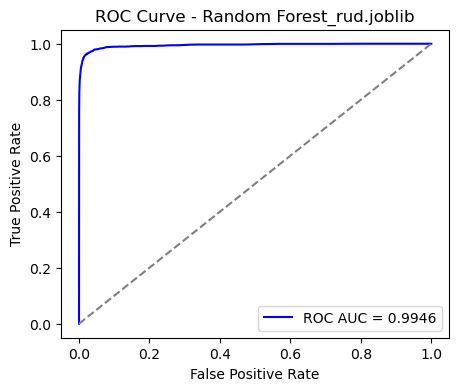

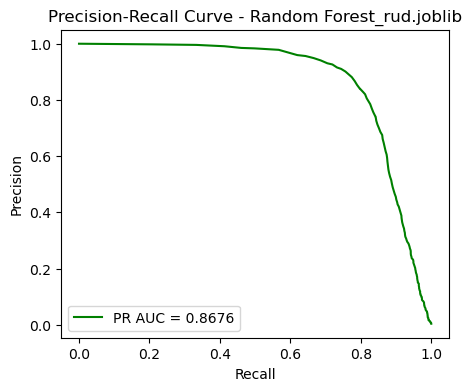


📌 XGBoost_nearmiss.joblib
Confusion Matrix:
 [[431549 122025]
 [    25   2120]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.7796    0.8761    553574
           1     0.0171    0.9883    0.0336      2145

    accuracy                         0.7804    555719
   macro avg     0.5085    0.8840    0.4548    555719
weighted avg     0.9961    0.7804    0.8729    555719

ROC AUC: 0.9829946963921826
PR AUC: 0.5198554967387282


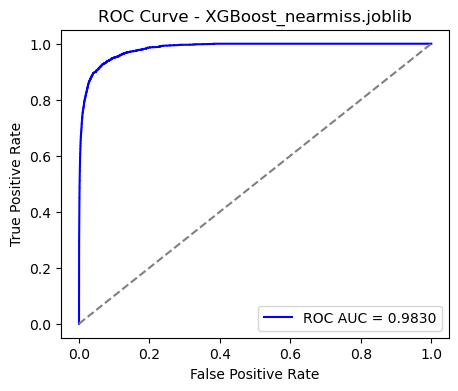

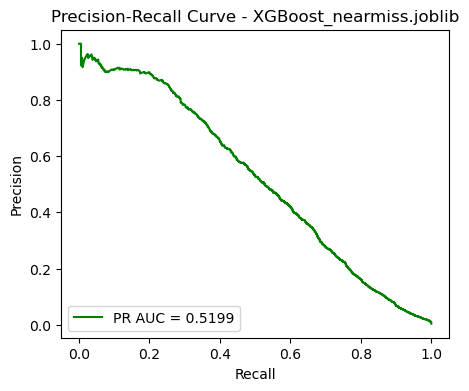


📌 XGBoost_raw.joblib
Confusion Matrix:
 [[553123    451]
 [   136   2009]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9992    0.9995    553574
           1     0.8167    0.9366    0.8725      2145

    accuracy                         0.9989    555719
   macro avg     0.9082    0.9679    0.9360    555719
weighted avg     0.9990    0.9989    0.9990    555719

ROC AUC: 0.9989468937105567
PR AUC: 0.9571943724422911


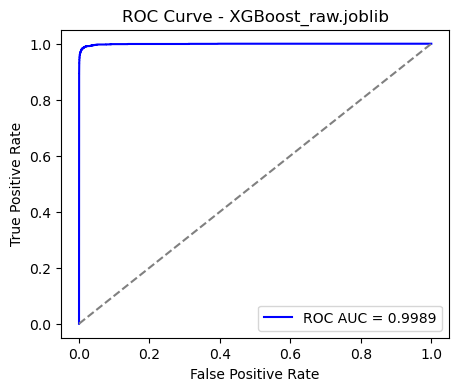

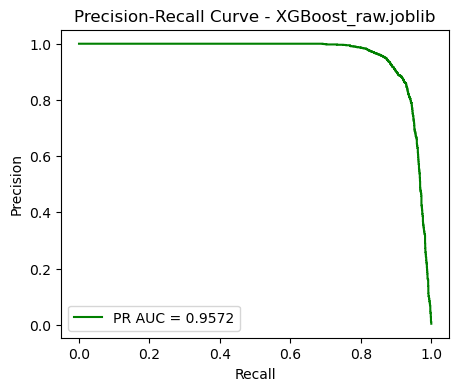


📌 XGBoost_rud.joblib
Confusion Matrix:
 [[545985   7589]
 [    54   2091]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9863    0.9930    553574
           1     0.2160    0.9748    0.3537      2145

    accuracy                         0.9862    555719
   macro avg     0.6080    0.9806    0.6734    555719
weighted avg     0.9969    0.9862    0.9906    555719

ROC AUC: 0.9984212717894213
PR AUC: 0.9023037617838349


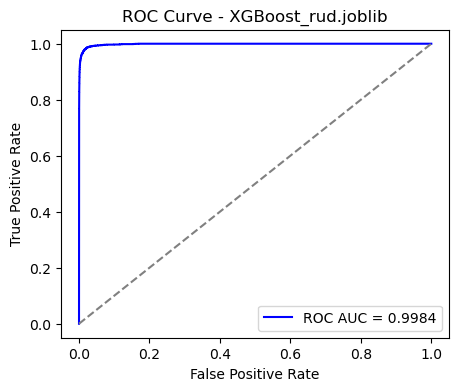

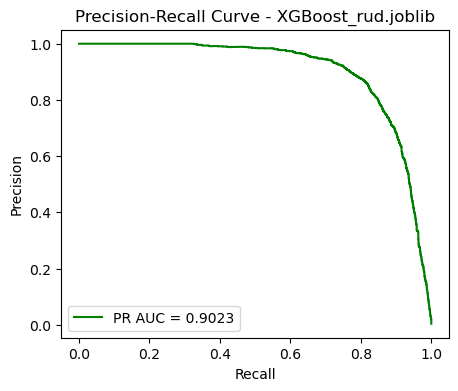


📌 XGBoost_SMOTE.joblib
Confusion Matrix:
 [[551928   1646]
 [   130   2015]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9970    0.9984    553574
           1     0.5504    0.9394    0.6941      2145

    accuracy                         0.9968    555719
   macro avg     0.7751    0.9682    0.8463    555719
weighted avg     0.9980    0.9968    0.9972    555719

ROC AUC: 0.9960059729855637
PR AUC: 0.9290014190493046


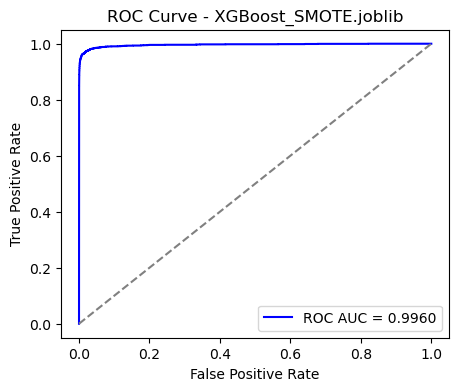

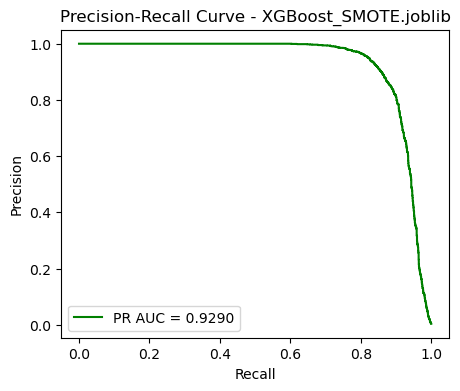


📌 Decision Tree_nearmiss.joblib
Confusion Matrix:
 [[379396 174178]
 [    64   2081]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.6854    0.8133    553574
           1     0.0118    0.9702    0.0233      2145

    accuracy                         0.6865    555719
   macro avg     0.5058    0.8278    0.4183    555719
weighted avg     0.9960    0.6865    0.8102    555719

ROC AUC: 0.8277602513484256
PR AUC: 0.0115693872195161


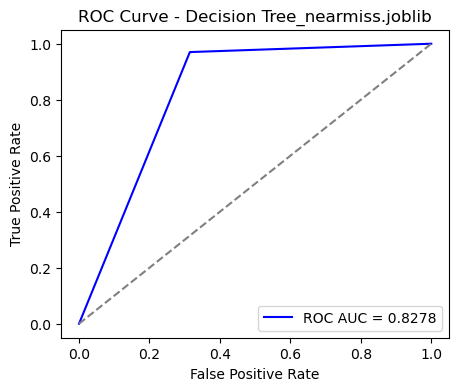

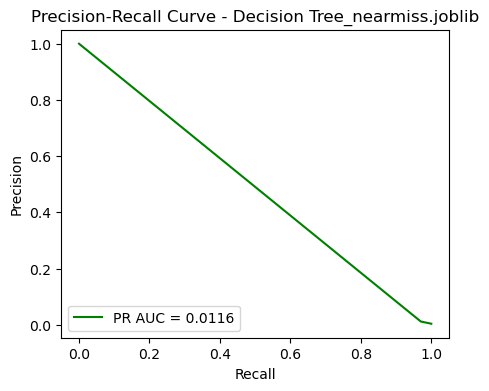


📌 Decision Tree_rud.joblib
Confusion Matrix:
 [[532321  21253]
 [   116   2029]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9616    0.9803    553574
           1     0.0871    0.9459    0.1596      2145

    accuracy                         0.9615    555719
   macro avg     0.5435    0.9538    0.5700    555719
weighted avg     0.9963    0.9615    0.9772    555719

ROC AUC: 0.9537642040651575
PR AUC: 0.082644663057503


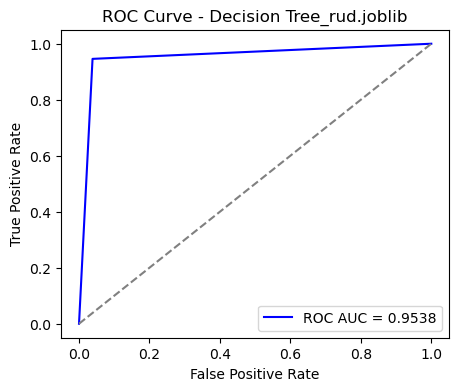

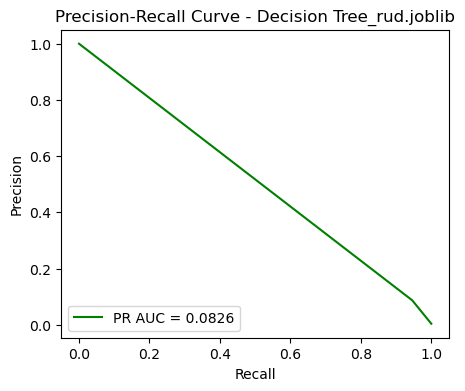

In [97]:
# === Step 2: Run evaluation for each model ===
for model_file in models:
    evaluate_model(model_file, X_scaled, y)

In [103]:
# Create dictionary of results
results = {
    "Model": [
        "Logistic Regression_nearmiss",
        "Logistic Regression_raw",
        "Logistic Regression_rud",
        "Logistic Regression_SMOTE",
        "Random Forest_nearmiss",
        "Random Forest_rud",
        "XGBoost_nearmiss",
        "XGBoost_raw",
        "XGBoost_rud",
        "XGBoost_SMOTE",
        "Decision Tree_nearmiss",
        "Decision Tree_rud"
    ],
    "Accuracy": [
        0.7709, 0.9485, 0.9501, 0.9441,
        0.5438, 0.9801, 0.7804, 0.9989,
        0.9862, 0.9968, 0.6865, 0.9615
    ],
    "Precision (class 1)": [
        0.0144, 0.0600, 0.0619, 0.0553,
        0.0082, 0.1578, 0.0171, 0.8167,
        0.2160, 0.5504, 0.0118, 0.0871
    ],
    "Recall (class 1)": [
        0.8681, 0.8410, 0.8424, 0.8387,
        0.9772, 0.9608, 0.9883, 0.9366,
        0.9748, 0.9394, 0.9702, 0.9459
    ],
    "F1 (class 1)": [
        0.0284, 0.1119, 0.1153, 0.1038,
        0.0163, 0.2711, 0.0336, 0.8725,
        0.3537, 0.6941, 0.0233, 0.1596
    ],
    "ROC AUC": [
        0.8960, 0.9411, 0.9403, 0.9412,
        0.9672, 0.9946, 0.9830, 0.9989,
        0.9984, 0.9960, 0.8278, 0.9538
    ],
    "PR AUC": [
        0.1400, 0.2054, 0.2051, 0.2072,
        0.6045, 0.8676, 0.5199, 0.9572,
        0.9023, 0.9290, 0.0116, 0.0826
    ]
}

# Convert to DataFrame
df = pd.DataFrame(results)

# Highlight the best per column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

df_styled = df.style.apply(highlight_max, subset=["Accuracy","Precision (class 1)","Recall (class 1)","F1 (class 1)","ROC AUC","PR AUC"])

# Show the table
df_styled


,Model,Accuracy,Precision (class 1),Recall (class 1),F1 (class 1),ROC AUC,PR AUC
0,Logistic Regression_nearmiss,0.770900,0.014400,0.868100,0.028400,0.896000,0.140000
1,Logistic Regression_raw,0.948500,0.060000,0.841000,0.111900,0.941100,0.205400
2,Logistic Regression_rud,0.950100,0.061900,0.842400,0.115300,0.940300,0.205100
3,Logistic Regression_SMOTE,0.944100,0.055300,0.838700,0.103800,0.941200,0.207200
4,Random Forest_nearmiss,0.543800,0.008200,0.977200,0.016300,0.967200,0.604500
5,Random Forest_rud,0.980100,0.157800,0.960800,0.271100,0.994600,0.867600
6,XGBoost_nearmiss,0.780400,0.017100,0.988300,0.033600,0.983000,0.519900
7,XGBoost_raw,0.998900,0.816700,0.936600,0.872500,0.998900,0.957200
8,XGBoost_rud,0.986200,0.216000,0.974800,0.353700,0.998400,0.902300
9,XGBoost_SMOTE,0.996800,0.550400,0.939400,0.694100,0.996000,0.929000
